# bibliotecas utilizadas

In [1]:
# load libraries and set plot parameters
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75
plt.rcParams['figure.autolayout'] = False
#plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['figure.figsize'] = 14, 8
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"

import scipy.constants as cte
from scipy.integrate import simps
from scipy.signal import gaussian

from multiprocessing import Pool

from core.evolution import imaginary
from core.empirical import in_segregation

au_l   = cte.value('atomic unit of length')
au_t   = cte.value('atomic unit of time')
au_e   = cte.value('atomic unit of energy')
ev     = cte.value('electron volt')
au2ang = au_l / 1e-10
au2ev  = au_e / ev

## função que gera o perfil de concentração

In [2]:
def concentration(x0, R, ml):
    # 2 monolayers requires 100 surrounding
    # 20 monolayers requires 10 surrounding
    # but let's force at least 10
    nsl = max(10,int(110+(10-100/(20-2))*ml)) # number of surrounding layers (each side)
    
    tl = ml + 2 * nsl  # total layers
    # bulk before well
    x = [0] * nsl
    # well
    for n in range(1, ml+1):
        x.append(in_segregation(x0, R, n))
    # barrier after well
    for n in range(1, nsl+1):
        x.append(in_segregation(x0, R, n+ml, ml))
    return np.arange(1, len(x)+1), np.array(x)

## parâmetros buscados

In [3]:
x0      = 0.14
tT      = [525, 475]
tR      = [0.867, 0.778]
N       = 1024
offset  = (0.7, 0.3)
ml_grid = [10, 15, 21, 28]

## parâmetros de acordo com Martini

In [4]:
a0   = np.vectorize(lambda x:  6.0584 * x + (1-x) *  5.6533 )
a    = np.vectorize(lambda x: -6.08   * x + (1-x) * -8.33   )
b    = np.vectorize(lambda x: -1.8    * x + (1-x) * -1.7    )
c11  = np.vectorize(lambda x:  0.8329 * x + (1-x) *  1.1879 )
c12  = np.vectorize(lambda x:  0.4526 * x + (1-x) *  0.5376 )
me   = np.vectorize(lambda x:  0.023  * x + (1-x) *  0.067  )
mhhz = np.vectorize(lambda x:  0.263  * x + (1-x) *  0.333  )
eps  = np.vectorize(lambda x: 15.15   * x + (1-x) * 13.1    )

## cálculo de acordo com o número de monolayers

In [8]:
PL_numeric   = {}
PLR_envelope = {}
PLR_e_hh     = {}
PLR_hh       = {}
infos_e      = []
infos_h      = []

# R = tR[0]
# T = tT[0]
# for gapx in np.linspace(0.67,0.68,10):
for R, T in zip(tR, tT):
    PL_numeric[T]   = []
    PLR_envelope[T] = []
    PLR_e_hh[T]     = []
    PLR_hh[T]       = []

    for ml in ml_grid:
        layers, in_x = concentration(x0, R, ml)

        def concentration_z(z):
            position = 0.0
            for x, a in zip(in_x, a0(in_x)):
                position += a/2.0
                if z < position:
                    return x
            return in_x[0]

        z      = np.linspace(0.0, np.sum(a0(in_x))/2.0, N)
        in_x_z = np.vectorize(concentration_z)(z)

        #gap    = np.vectorize(lambda x: 1.5192-1.5837*x+0.475*x**2)(in_x_z)
        gap_2   = np.vectorize(lambda x: 0.422+0.7*(1-x)+0.4*(1-x)**2)(in_x_z)
        gap_77  = np.vectorize(lambda x: 1.508-1.47*x+0.375*x**2)(in_x_z)
        gap_300 = np.vectorize(lambda x: 0.324+0.7*(1-x)+0.4*(1-x)**2)(in_x_z)
        #gap = gap_2 + (77-2)*(gap_300-gap_2)/(300-2)
        gap = gap_77#gap_2*gapx + gap_300*(1-gapx)
        

        #gap = np.vectorize(lambda x: 1.519-(6*(1-x)**2-8.6*(1-x)+5.2)*(0.0001*T**2)/(T+(377*(1-x)**2-455*(1-x)+196)))(in_x_z)
        _a   = a(in_x_z)
        _b   = b(in_x_z)
        _c11 = c11(in_x_z)
        _c12 = c12(in_x_z)
        _epp = (a0([0])[0]-a0(in_x_z))/a0(in_x_z)
        _me  = me(in_x_z)
        _mhh = mhhz(in_x_z)
        _eps = eps(in_x_z)
        _exciton = lambda i: 0.007#(13.6/(1.0/_me[i]+1.0/_mhh[i]))/(_eps[i]**2)
        
        
        gap_strain = gap + (2*_a*(_c11-_c12)-_b*(_c11+2*_c12))*_epp/_c11

        gap_c      = offset[0] * gap_strain
        gap_v      = offset[1] * gap_strain

        z_au    = z/au2ang # angstrom to au
        v_e_au  = (gap_c-np.min(gap_c))/au2ev # eV to au
        v_hh_au = (gap_v-np.min(gap_v))/au2ev # eV to au

        electron   = imaginary(z_au,v_e_au ,  np.max(_me))
        infos_e.append(electron)
        heavy_hole = imaginary(z_au,v_hh_au, np.max(_mhh))
        infos_h.append(heavy_hole)

        Ee      = electron['eigenvalues'][0]* au2ev
        Ce      = electron['counters'][0]
        Pe      = electron['precisions'][0]
        Te      = electron['timers'][0]
        Se      = electron['squared_euclidean_dist'][0]
        Ee_es   = electron['eigenstates'][0]

        Ehh     = heavy_hole['eigenvalues'][0]* au2ev
        Chh     = heavy_hole['counters'][0]
        Phh     = heavy_hole['precisions'][0]
        Thh     = heavy_hole['timers'][0]
        Shh     = heavy_hole['squared_euclidean_dist'][0]
        Ehh_es  = heavy_hole['eigenstates'][0]

        ###############################################################
        envelope  = Ee_es + Ehh_es
        envelope  = envelope  / np.sqrt(simps(envelope.conj()*envelope, z))
        z_med     = simps(envelope.conj()*z*envelope,z)
        idx = np.max([i if _z < z_med else 0 for i, _z in enumerate(z)])
        gap_min = gap_strain[idx]
        plr_envelope = gap_min+Ehh+Ee-_exciton[idx]
        PLR_envelope[T].append(plr_envelope)

        ###############################################################
        Ee_es  = Ee_es   / np.sqrt(simps(Ee_es.conj()  * Ee_es  , z))
        Ehh_es = Ehh_es  / np.sqrt(simps(Ehh_es.conj() * Ehh_es , z))
        z_med  = simps(Ehh_es.conj()*z*Ee_es,z)
        idx = np.max([i if _z < z_med else 0 for i, _z in enumerate(z)])
        gap_min = gap_strain[idx]
        plr_e_hh = gap_min+Ehh+Ee-_exciton[idx]
        PLR_e_hh[T].append(plr_e_hh)

        ###############################################################
        Ehh_es = Ehh_es  / np.sqrt(simps(Ehh_es.conj() * Ehh_es , z))
        z_med  = simps(Ehh_es.conj()*z*Ehh_es,z)/simps(Ehh_es.conj()*Ehh_es,z)
        idx = np.max([i if _z < z_med else 0 for i, _z in enumerate(z)])
        gap_min = gap_strain[idx]
        plr_hh = gap_min+Ehh+Ee-_exciton[idx]
        PLR_hh[T].append(plr_hh)

        ###############################################################
        idx = np.argmin(gap_strain)
        gap_min = gap_strain[idx]
        pl = gap_min+Ehh+Ee-_exciton[idx]
        PL_numeric[T].append(pl)

        #print("GAP x: %.4f" % gapx)
        print("ML={0:02d}, T={1} C, R={2:.3f}, PL={3:.8f} eV, PL_env={4:.8f} eV, PL_e_hh={5:.8f} eV, PL_hh={6:.8f} eV, ".format(
            ml, T, R, pl, plr_envelope, plr_e_hh, plr_hh))

ML=10, T=525 C, R=0.867, PL=1.47286495 eV, PL_env=1.47286495 eV, PL_e_hh=1.50901228 eV, PL_hh=1.47286495 eV, 
ML=15, T=525 C, R=0.867, PL=1.45187158 eV, PL_env=1.45746622 eV, PL_e_hh=1.48097027 eV, PL_hh=1.46092447 eV, 
ML=21, T=525 C, R=0.867, PL=1.43086232 eV, PL_env=1.43834425 eV, PL_e_hh=1.44964853 eV, PL_hh=1.43834425 eV, 
ML=28, T=525 C, R=0.867, PL=1.41245962 eV, PL_env=1.41809727 eV, PL_e_hh=1.42447741 eV, PL_hh=1.41809727 eV, 
ML=10, T=475 C, R=0.778, PL=1.46764590 eV, PL_env=1.47527401 eV, PL_e_hh=1.54341699 eV, PL_hh=1.47527401 eV, 


KeyboardInterrupt: 

In [6]:
# 2K
# ML=10, T=525 C, R=0.867, PL=1.48259237 eV, PL_env=1.48959237 eV, PL_e_hh=1.52676609 eV, PL_hh=1.48959237 eV, 
# ML=15, T=525 C, R=0.867, PL=1.46085512 eV, PL_env=1.47360027 eV, PL_e_hh=1.49775218 eV, PL_hh=1.47715228 eV, 
# ML=21, T=525 C, R=0.867, PL=1.43923791 eV, PL_env=1.45391813 eV, PL_e_hh=1.46552684 eV, PL_hh=1.45391813 eV, 
# ML=28, T=525 C, R=0.867, PL=1.42039691 eV, PL_env=1.43318255 eV, PL_e_hh=1.43973195 eV, PL_hh=1.43318255 eV, 
# ML=10, T=475 C, R=0.778, PL=1.47705049 eV, PL_env=1.49188235 eV, PL_e_hh=1.56196239 eV, PL_hh=1.49188235 eV, 
# ML=15, T=475 C, R=0.778, PL=1.45306677 eV, PL_env=1.46597776 eV, PL_e_hh=1.48943505 eV, PL_hh=1.46597776 eV, 
# ML=21, T=475 C, R=0.778, PL=1.43090781 eV, PL_env=1.44154059 eV, PL_e_hh=1.44914059 eV, PL_hh=1.44154059 eV, 
# ML=28, T=475 C, R=0.778, PL=1.41314403 eV, PL_env=1.42162136 eV, PL_e_hh=1.42440333 eV, PL_hh=1.42162136 eV, 

# 300K
# ML=10, T=525 C, R=0.867, PL=1.38459237 eV, PL_env=1.39159237 eV, PL_e_hh=1.42876609 eV, PL_hh=1.39159237 eV, 
# ML=15, T=525 C, R=0.867, PL=1.36285512 eV, PL_env=1.37560027 eV, PL_e_hh=1.39975218 eV, PL_hh=1.37915228 eV, 
# ML=21, T=525 C, R=0.867, PL=1.34123791 eV, PL_env=1.35591813 eV, PL_e_hh=1.36752684 eV, PL_hh=1.35591813 eV, 
# ML=28, T=525 C, R=0.867, PL=1.32239691 eV, PL_env=1.33518255 eV, PL_e_hh=1.34173195 eV, PL_hh=1.33518255 eV, 
# ML=10, T=475 C, R=0.778, PL=1.37905049 eV, PL_env=1.39388235 eV, PL_e_hh=1.46396239 eV, PL_hh=1.39388235 eV, 
# ML=15, T=475 C, R=0.778, PL=1.35506677 eV, PL_env=1.36797776 eV, PL_e_hh=1.39143505 eV, PL_hh=1.36797776 eV, 
# ML=21, T=475 C, R=0.778, PL=1.33290781 eV, PL_env=1.34354059 eV, PL_e_hh=1.35114059 eV, PL_hh=1.34354059 eV, 
# ML=28, T=475 C, R=0.778, PL=1.31514403 eV, PL_env=1.32362136 eV, PL_e_hh=1.32640333 eV, PL_hh=1.32362136 eV, 

PL_experiment = {
    525: [1.45091, 1.42051, 1.39425, 1.37454],
    475: [1.43681, 1.40565, 1.38018, 1.36112]
}

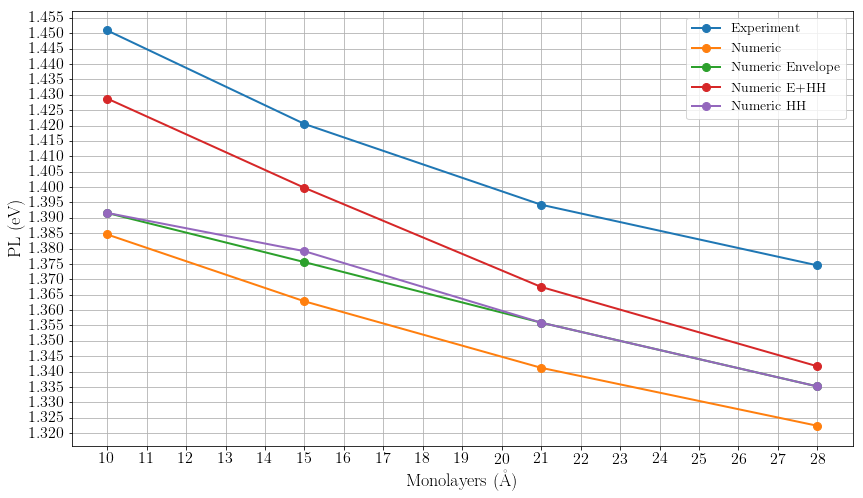

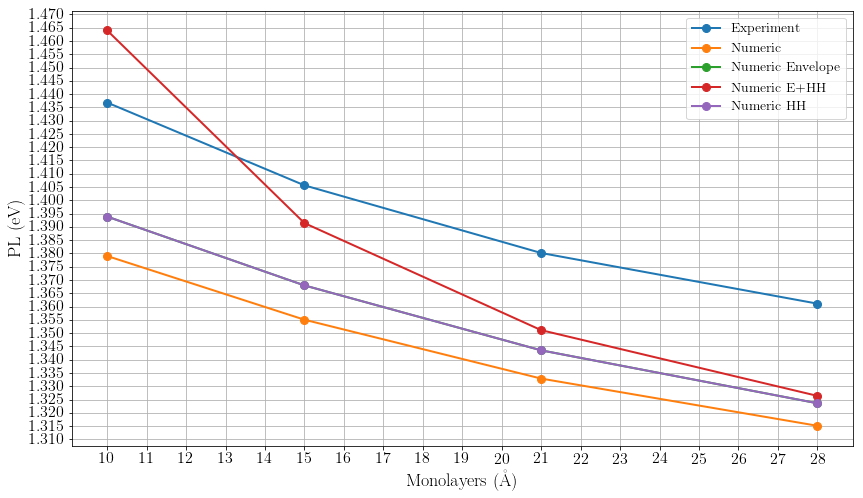

In [9]:
for T in tT:
    fig = plt.figure()
    ax  = fig.gca()

    ax.set_xticks(np.arange(0, 30, 1))
    ax.set_yticks(np.arange(0,  1.6, 0.005))
    ax.set_xlabel('Monolayers (\AA)')
    ax.set_ylabel('PL (eV)')

    ax.plot(ml_grid, PL_experiment[T], '-o', label='Experiment')
    ax.plot(ml_grid, PL_numeric[T]   , '-o', label='Numeric')
    ax.plot(ml_grid, PLR_envelope[T] , '-o', label='Numeric Envelope')
    ax.plot(ml_grid, PLR_e_hh[T]     , '-o', label='Numeric E+HH')
    ax.plot(ml_grid, PLR_hh[T]       , '-o', label='Numeric HH')

    plt.legend()
    plt.grid(True)
    plt.plot()

In [ ]:
[1.45091, 1.42051, 1.39425, 1.37454]

In [ ]:
#massa max

GAP x: 0.00, ML=28, T=525 C, R=0.867, PL=1.32239691 eV, PL_env=1.33518255 eV, PL_e_hh=1.34173195 eV, PL_hh=1.33518255 eV, 
GAP x: 0.11, ML=28, T=525 C, R=0.867, PL=1.33328580 eV, PL_env=1.34607144 eV, PL_e_hh=1.35262084 eV, PL_hh=1.34607144 eV, 
GAP x: 0.22, ML=28, T=525 C, R=0.867, PL=1.34417468 eV, PL_env=1.35696033 eV, PL_e_hh=1.36350973 eV, PL_hh=1.35696033 eV, 
GAP x: 0.33, ML=28, T=525 C, R=0.867, PL=1.35506357 eV, PL_env=1.36784922 eV, PL_e_hh=1.37439862 eV, PL_hh=1.36784922 eV, 
GAP x: 0.44, ML=28, T=525 C, R=0.867, PL=1.36595246 eV, PL_env=1.37873811 eV, PL_e_hh=1.38528750 eV, PL_hh=1.37873811 eV, 
GAP x: 0.56, ML=28, T=525 C, R=0.867, PL=1.37684135 eV, PL_env=1.38962700 eV, PL_e_hh=1.39617639 eV, PL_hh=1.38962700 eV, 
GAP x: 0.67, ML=28, T=525 C, R=0.867, PL=1.38773024 eV, PL_env=1.40051589 eV, PL_e_hh=1.40706528 eV, PL_hh=1.40051589 eV, 
GAP x: 0.78, ML=28, T=525 C, R=0.867, PL=1.39861913 eV, PL_env=1.41140477 eV, PL_e_hh=1.41795417 eV, PL_hh=1.41140477 eV, 
GAP x: 0.89, ML=28, T=525 C, R=0.867, PL=1.40950802 eV, PL_env=1.42229366 eV, PL_e_hh=1.42884306 eV, PL_hh=1.42229366 eV, 
GAP x: 1.00, ML=28, T=525 C, R=0.867, PL=1.42039691 eV, PL_env=1.43318255 eV, PL_e_hh=1.43973195 eV, PL_hh=1.43318255 eV, 
    
#massa min

GAP x: 0.00, ML=28, T=525 C, R=0.867, PL=1.32419230 eV, PL_env=1.33697795 eV, PL_e_hh=1.34352734 eV, PL_hh=1.33697795 eV, 
GAP x: 0.11, ML=28, T=525 C, R=0.867, PL=1.33508119 eV, PL_env=1.34786684 eV, PL_e_hh=1.35441623 eV, PL_hh=1.34786684 eV, 
GAP x: 0.22, ML=28, T=525 C, R=0.867, PL=1.34597008 eV, PL_env=1.35875573 eV, PL_e_hh=1.36530512 eV, PL_hh=1.35875573 eV, 
GAP x: 0.33, ML=28, T=525 C, R=0.867, PL=1.35685897 eV, PL_env=1.36964461 eV, PL_e_hh=1.37619401 eV, PL_hh=1.36964461 eV, 
GAP x: 0.44, ML=28, T=525 C, R=0.867, PL=1.36774786 eV, PL_env=1.38053350 eV, PL_e_hh=1.38708290 eV, PL_hh=1.38053350 eV, 
GAP x: 0.56, ML=28, T=525 C, R=0.867, PL=1.37863675 eV, PL_env=1.39142239 eV, PL_e_hh=1.39797179 eV, PL_hh=1.39142239 eV, 
GAP x: 0.67, ML=28, T=525 C, R=0.867, PL=1.38952564 eV, PL_env=1.40231128 eV, PL_e_hh=1.40886068 eV, PL_hh=1.40231128 eV, 
GAP x: 0.78, ML=28, T=525 C, R=0.867, PL=1.40041452 eV, PL_env=1.41320017 eV, PL_e_hh=1.41974957 eV, PL_hh=1.41320017 eV, 
GAP x: 0.89, ML=28, T=525 C, R=0.867, PL=1.41130341 eV, PL_env=1.42408906 eV, PL_e_hh=1.43063846 eV, PL_hh=1.42408906 eV, 
GAP x: 1.00, ML=28, T=525 C, R=0.867, PL=1.42219230 eV, PL_env=1.43497795 eV, PL_e_hh=1.44152734 eV, PL_hh=1.43497795 eV, 

In [ ]:
#massa max

GAP x: 0.00, ML=10, T=525 C, R=0.867, PL=1.38459237 eV, PL_env=1.39159237 eV, PL_e_hh=1.42876609 eV, PL_hh=1.39159237 eV, 
GAP x: 0.11, ML=10, T=525 C, R=0.867, PL=1.39548126 eV, PL_env=1.40248126 eV, PL_e_hh=1.43965498 eV, PL_hh=1.40248126 eV, 
GAP x: 0.22, ML=10, T=525 C, R=0.867, PL=1.40637015 eV, PL_env=1.41337015 eV, PL_e_hh=1.45054387 eV, PL_hh=1.41337015 eV, 
GAP x: 0.33, ML=10, T=525 C, R=0.867, PL=1.41725904 eV, PL_env=1.42425904 eV, PL_e_hh=1.46143276 eV, PL_hh=1.42425904 eV, 
GAP x: 0.44, ML=10, T=525 C, R=0.867, PL=1.42814793 eV, PL_env=1.43514793 eV, PL_e_hh=1.47232164 eV, PL_hh=1.43514793 eV, 
GAP x: 0.56, ML=10, T=525 C, R=0.867, PL=1.43903682 eV, PL_env=1.44603682 eV, PL_e_hh=1.48321053 eV, PL_hh=1.44603682 eV, 
GAP x: 0.67, ML=10, T=525 C, R=0.867, PL=1.44992571 eV, PL_env=1.45692571 eV, PL_e_hh=1.49409942 eV, PL_hh=1.45692571 eV, 
GAP x: 0.78, ML=10, T=525 C, R=0.867, PL=1.46081460 eV, PL_env=1.46781460 eV, PL_e_hh=1.50498831 eV, PL_hh=1.46781460 eV, 
GAP x: 0.89, ML=10, T=525 C, R=0.867, PL=1.47170349 eV, PL_env=1.47870349 eV, PL_e_hh=1.51587720 eV, PL_hh=1.47870349 eV, 
GAP x: 1.00, ML=10, T=525 C, R=0.867, PL=1.48259237 eV, PL_env=1.48959237 eV, PL_e_hh=1.52676609 eV, PL_hh=1.48959237 eV, 

#massa min

GAP x: 0.00, ML=10, T=525 C, R=0.867, PL=1.38552621 eV, PL_env=1.39252621 eV, PL_e_hh=1.44092266 eV, PL_hh=1.39252621 eV, 
GAP x: 0.11, ML=10, T=525 C, R=0.867, PL=1.39641510 eV, PL_env=1.40341510 eV, PL_e_hh=1.45181155 eV, PL_hh=1.40341510 eV, 
GAP x: 0.22, ML=10, T=525 C, R=0.867, PL=1.40730399 eV, PL_env=1.41430399 eV, PL_e_hh=1.46270044 eV, PL_hh=1.41430399 eV, 
GAP x: 0.33, ML=10, T=525 C, R=0.867, PL=1.41819288 eV, PL_env=1.42519288 eV, PL_e_hh=1.47358933 eV, PL_hh=1.42519288 eV, 
GAP x: 0.44, ML=10, T=525 C, R=0.867, PL=1.42908177 eV, PL_env=1.43608177 eV, PL_e_hh=1.48447822 eV, PL_hh=1.43608177 eV, 
GAP x: 0.56, ML=10, T=525 C, R=0.867, PL=1.43997065 eV, PL_env=1.44697065 eV, PL_e_hh=1.49536711 eV, PL_hh=1.44697065 eV, 
GAP x: 0.67, ML=10, T=525 C, R=0.867, PL=1.45085954 eV, PL_env=1.45785954 eV, PL_e_hh=1.50625600 eV, PL_hh=1.45785954 eV, 
GAP x: 0.78, ML=10, T=525 C, R=0.867, PL=1.46174843 eV, PL_env=1.46874843 eV, PL_e_hh=1.51714489 eV, PL_hh=1.46874843 eV, 
GAP x: 0.89, ML=10, T=525 C, R=0.867, PL=1.47263732 eV, PL_env=1.47963732 eV, PL_e_hh=1.52803378 eV, PL_hh=1.47963732 eV, 
GAP x: 1.00, ML=10, T=525 C, R=0.867, PL=1.48352621 eV, PL_env=1.49052621 eV, PL_e_hh=1.53892266 eV, PL_hh=1.49052621 eV, 